# Objective: Analysis of the trends of post-secondary education in Singapore

1. Junior Collage(JC) or Polytechnic 
   1. Which is more popular?
   2. Which is harder to graduate?
2. Which field of study should I go into
   1. Which field of study is more popular?
   2. Which field of study has better job prospects?

In [20]:
# Importing libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
sns.set(font_scale=1.3)

## For the first sub-objective
**JC or Polytechnic**

Datasets used are:
- enrolment-secondary-by-level-and-course.csv
- polytechnics-intake-enrolment-and-graduates-by-course.csv
- enrolment-pre-university-by-level-and-course.csv

In [22]:
# Reading in the data needed for the analysis
ori_sec_enrol = pd.read_csv('data/enrolment-secondary-by-level-and-course.csv', parse_dates=['year'])
ori_poly_all = pd.read_csv('data/polytechnics-intake-enrolment-and-graduates-by-course.csv', parse_dates=['year'])
ori_post_sec_all = pd.read_csv('data/enrolment-pre-university-by-level-and-course.csv', parse_dates=['year'])

Some simple text summaries of the dataset here

In [23]:
print('How does the raw data look like?')
display(ori_sec_enrol.head())
print()

print('Summary of the data at a glance')
display(ori_sec_enrol.describe(include='all'))
print()

print('More technical info of the dataset')
display(ori_sec_enrol.info())
print()

print('Looking for null values')
display(ori_sec_enrol.isnull().sum())

How does the raw data look like?


,year,level,course,sex,enrolment_secondary
0,1980-01-01,Secondary 1,Express,MF,45489
1,1980-01-01,Secondary 1,Express,F,22509
2,1980-01-01,Secondary 1,Normal (Acad),MF,0
3,1980-01-01,Secondary 1,Normal (Acad),F,0
4,1980-01-01,Secondary 1,Normal (Tech),MF,0



Summary of the data at a glance


,year,level,course,sex,enrolment_secondary
count,1318,1318,1318,1318,1318.000000
unique,39,5,4,2,NaN
top,1980-01-01 00:00:00,Secondary 1,Normal (Acad),MF,NaN
freq,34,310,390,659,NaN
first,1980-01-01 00:00:00,NaN,NaN,NaN,NaN
last,2018-01-01 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,8017.500000
std,NaN,NaN,NaN,NaN,8187.688607
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,1978.000000



More technical info of the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 5 columns):
year                   1318 non-null datetime64[ns]
level                  1318 non-null object
course                 1318 non-null object
sex                    1318 non-null object
enrolment_secondary    1318 non-null int64
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 51.6+ KB


None


Looking for null values


year                   0
level                  0
course                 0
sex                    0
enrolment_secondary    0
dtype: int64

Now we need to get the total number of students able to enrol for post-secondary education for the current year.  
For this we will be assuming all the Secondary 4 Express and NA and Secondary 5 students of the previous years are eligible for enrolling in the current year

In [24]:
# Displaying before
print('Before')
display(ori_sec_enrol.head())

# Making sure the original dataset is not touched
sec_enrol = ori_sec_enrol

# Filtering for only Secondary 4 express students and Secondary 5 students
sec_4_filter = sec_enrol['level'].isin(['Secondary 4'])
express_filter = sec_enrol['course'].isin(['Express', 'Normal (Acad)'])
sec_5_grad_filter = sec_enrol['level'].isin(['Secondary 5'])
sec_4_grad_filter = sec_4_filter & express_filter
# Only total filter
mf_filter = sec_enrol['sex'].isin(['MF'])
all_sec_grad_filter = sec_4_grad_filter | sec_5_grad_filter
all_sec_grad_filter = all_sec_grad_filter & mf_filter
all_sec_grad = sec_enrol[all_sec_grad_filter]
# Grouping them by year and getting total grads by years
df_sec_grad = all_sec_grad.groupby(['year'])['enrolment_secondary'].sum().reset_index()
# Getting enrolment_year
df_sec_grad['enrol_year'] = df_sec_grad['year'] + pd.offsets.DateOffset(years=1)
df_sec_grad = df_sec_grad.drop(['year'], axis=1)

# Showing the data after the manipulation
print('After')
display(df_sec_grad.head())

Before


,year,level,course,sex,enrolment_secondary
0,1980-01-01,Secondary 1,Express,MF,45489
1,1980-01-01,Secondary 1,Express,F,22509
2,1980-01-01,Secondary 1,Normal (Acad),MF,0
3,1980-01-01,Secondary 1,Normal (Acad),F,0
4,1980-01-01,Secondary 1,Normal (Tech),MF,0


After


,enrolment_secondary,enrol_year
0,32925,1981-01-01
1,33931,1982-01-01
2,33938,1983-01-01
3,38023,1984-01-01
4,47677,1985-01-01


Now we need to get the prep the JCs and Poly Data  
For JC data, we can assume the enrolment of JC 1 are the intake for the year  

We will assume graduating in JC to be promoting to JC 2 in JC  
Thus we will be comparing the current year JC 2 to the previous year intake  

In [25]:
# Before
print('Before')
display(ori_post_sec_all.head())

# Making sure the original dataset is not touched
post_sec_all = ori_post_sec_all

# Seem the data we thought would be int is actually a string
# We realise this is because there is - in some of the values of enrolment_preu
# Cleaning these values by setting them to 0
post_sec_all = post_sec_all.replace({'-': '0'})
# Changing the type back to int
post_sec_all = post_sec_all.astype({'enrolment_preu': 'float32'})
# Getting the mf_filter to get totals only
mf_filter = post_sec_all['sex'].isin(['MF'])
# Getting only JC 1 data
jc_1_filter = post_sec_all['level'].isin(['Junior College 1'])
jc_1_filter = jc_1_filter & mf_filter
all_jc_1 = post_sec_all[jc_1_filter]
# Getting Only JC 2 data
jc_2_filter = post_sec_all['level'].isin(['Junior College 2'])
jc_2_filter = jc_2_filter & mf_filter
all_jc_2 = post_sec_all[jc_2_filter]

# Setting up the JC intake first, then calculate the graduate %
# jc 1 grping
grp_jc_1 = all_jc_1.groupby(['year'])['enrolment_preu'].sum().reset_index()
grp_jc_1 = grp_jc_1.rename(columns={'enrolment_preu': 'jc_intake'})
# jc 2 grping
grp_jc_2 = all_jc_2.groupby(['year'])['enrolment_preu'].sum().reset_index()
grp_jc_2 = grp_jc_2.rename(columns={'enrolment_preu': 'promoted'})
# Getting the year they promoted from
grp_jc_2['promo_year'] = grp_jc_2['year'] - pd.offsets.DateOffset(years=1)
# Dropping year col
grp_jc_2 = grp_jc_2.drop(['year'], axis=1)
df_jc = pd.merge(grp_jc_1, grp_jc_2, how='inner', left_on=['year'], right_on=['promo_year'])
# Dropping dup promo_year
df_jc = df_jc.drop(['promo_year'], axis=1)
df_jc['promo_per'] = df_jc['promoted'] / df_jc['jc_intake']
df_jc = df_jc.drop(['promoted'], axis=1)

# After
print('After')
display(df_jc.head())

Before


,year,level,course,sex,enrolment_preu
0,1980-01-01,Junior College 1,Arts,MF,1158
1,1980-01-01,Junior College 1,Arts,F,903
2,1980-01-01,Junior College 1,Commerce,MF,1210
3,1980-01-01,Junior College 1,Commerce,F,995
4,1980-01-01,Junior College 1,Science,MF,3301


After


,year,jc_intake,promo_per
0,1980-01-01,5669.0,0.953255
1,1981-01-01,5323.0,1.136389
2,1982-01-01,5709.0,1.026449
3,1983-01-01,6510.0,1.061137
4,1984-01-01,7801.0,1.003205


Now we will be cleaning the Polydataset

For this, we will be assuming that it takes the normal 3 years to finish a polytechnic diploma
Thus we will be calculating the % of graduating using that

In [26]:
# Before
print('Before')
display(ori_poly_all)

# Making sure the original dataset is not touched
poly_all = ori_poly_all

# CLeaning up all missing values
for i in ['intake', 'enrolment', 'graduates']:
    poly_all[i] = poly_all[i].str.replace(',', '')
    poly_all[i] = poly_all[i].str.replace('-', '0')
# Changing the type back to int
poly_all = poly_all.astype({'intake': 'float32', 'enrolment': 'float32', 'graduates': 'float32'})
# Getting the only total filters of MF
mf_filter = poly_all['sex'].isin(['MF'])
# Filtering out for only totals
all_poly = poly_all[mf_filter]
# Grouping the data by year
grp_all_poly = all_poly.groupby(['year'])['intake', 'graduates'].sum().reset_index()

# Calculate when the graduates year intake year was
poly_grads = grp_all_poly[['year', 'graduates']].copy()
poly_grads['intake_year'] = poly_grads['year'] - pd.offsets.DateOffset(years=3)
poly_grads = poly_grads.drop(['year'], axis=1)

# Merging the dataset together
grp_all_poly = grp_all_poly.drop(['graduates'], axis=1)
df_poly = pd.merge(grp_all_poly, poly_grads, how='inner', left_on=['year'], right_on=['intake_year'])
df_poly = df_poly.drop(['intake_year'], axis=1)
df_poly['graduate_per'] = df_poly['graduates'] / df_poly['intake']
df_poly = df_poly.drop(['graduates'], axis=1)

# After
print('After')
display(df_poly.head())

Before


,year,sex,course,intake,enrolment,graduates
0,2005-01-01,MF,Applied Arts,1128,2593,550
1,2005-01-01,F,Applied Arts,687,1538,302
2,2005-01-01,MF,"Architecture, Building & Real Estate",515,1466,425
3,2005-01-01,F,"Architecture, Building & Real Estate",312,870,249
4,2005-01-01,MF,Business & Administration,3483,10143,3044
...,...,...,...,...,...,...
331,2018-01-01,F,Mass Communication,500,"1,420",437
332,2018-01-01,MF,"Natural, Physical & Mathematical Sciences","1,232","3,794","1,353"
333,2018-01-01,F,"Natural, Physical & Mathematical Sciences",773,"2,308",825
334,2018-01-01,MF,Services,"1,083","3,279","1,053"


After


,year,intake,graduate_per
0,2005-01-01,20906.0,0.923993
1,2006-01-01,22276.0,0.907883
2,2007-01-01,23362.0,0.917944
3,2008-01-01,24838.0,0.922699
4,2009-01-01,25624.0,0.936583


Putting all the dataset together one at a time and mergin them properly

In [27]:
# Renaming some columns to be more specific
df_poly = df_poly.rename(columns={'intake': 'poly_intake'})
df_sec_grad = df_sec_grad.rename(columns={'enrolment_secondary': 'total_sec_grads'})

# Making the main DF I would be using
df_jc_poly = pd.merge(df_sec_grad, df_jc, left_on=['enrol_year'], right_on=['year'], how='inner')
df_jc_poly = df_jc_poly.drop(['enrol_year'], axis=1)
df_jc_poly = pd.merge(df_jc_poly, df_poly, how='inner', on='year')

# Calculating ratio that went to jc or poly
df_jc_poly['jc_intake_per'] = df_jc_poly['jc_intake'] / df_jc_poly['total_sec_grads']
df_jc_poly['poly_intake_per'] = df_jc_poly['poly_intake'] / df_jc_poly['total_sec_grads']
df_jc_poly['year_str'] = df_jc_poly['year'].dt.strftime('%Y')
df_jc_poly

,total_sec_grads,year,jc_intake,promo_per,poly_intake,graduate_per,jc_intake_per,poly_intake_per,year_str
0,48015,2005-01-01,15616.0,0.949091,20906.0,0.923993,0.325232,0.435406,2005
1,47161,2006-01-01,14633.0,0.933780,22276.0,0.907883,0.310278,0.472339,2006
2,49908,2007-01-01,16435.0,0.904411,23362.0,0.917944,0.329306,0.468101,2007
3,50007,2008-01-01,16148.0,0.900855,24838.0,0.922699,0.322915,0.496690,2008
4,49542,2009-01-01,16121.0,0.913343,25624.0,0.936583,0.325401,0.517218,2009
5,50445,2010-01-01,16327.0,0.904698,25707.0,0.939705,0.323659,0.509605,2010
6,50891,2011-01-01,16195.0,0.905156,26737.0,0.924599,0.318229,0.525378,2011
7,54472,2012-01-01,16155.0,0.903807,26754.0,0.920647,0.296574,0.491151,2012
8,54592,2013-01-01,16261.0,0.916364,26879.0,0.933963,0.297864,0.492362,2013
9,50979,2014-01-01,15337.0,0.928082,25777.0,0.939209,0.300849,0.505640,2014


## Now lets start makeing the graphs


Looking at trend in the intake of JC and Poly students

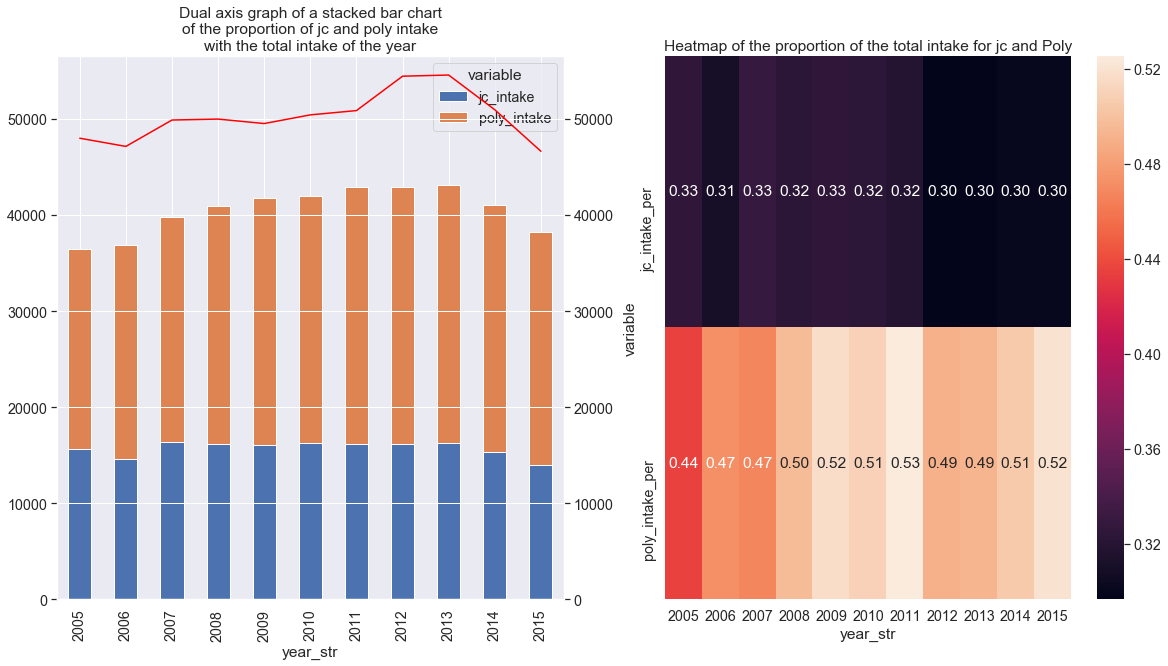

In [28]:
# Manipulating the df to make the data needed for graphs
grp_intake = df_jc_poly[['year_str', 'jc_intake', 'poly_intake']]
grp_intake = grp_intake.melt(id_vars=['year_str'], value_vars=['jc_intake', 'poly_intake'])
grp_intake_p = grp_intake.pivot('year_str', 'variable', 'value')

total_sec = df_jc_poly[['year_str', 'total_sec_grads']]

intake_per = df_jc_poly[['year_str', 'jc_intake_per', 'poly_intake_per']]
intake_per = intake_per.melt(id_vars=['year_str'], value_vars=['jc_intake_per', 'poly_intake_per'])
intake_per_p = intake_per.pivot('variable', 'year_str', 'value')

# Creating the subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plotting the first figure, stacked barplot with lineplot
# Setting the yaxis to have the same range and scale, then creating the dual axis
ax[0].set_ylim(0, total_sec['total_sec_grads'].max() + 2000)
dual_ax = ax[0].twinx()
dual_ax.set_ylim(0, total_sec['total_sec_grads'].max() + 2000)
# Plotting the graphs on the first ax
grp_intake_p.plot(kind='bar', stacked=True, ax=ax[0])
sns.lineplot(x='year_str', y='total_sec_grads', data=total_sec, ax=dual_ax, color='red')
dual_ax.set(ylabel='')

# Plotting the second heatmap
sns.heatmap(intake_per_p, annot=True, fmt='.2f', ax=ax[1])

# Adding titles
ax[0].set_title('Dual axis graph of a stacked bar chart\nof the proportion of jc and poly intake\nwith the total intake of the year')
ax[1].set_title('Heatmap of the proportion of the total intake for jc and Poly')

# Saving the figure
plt.savefig('plots/sub_1_1.png', bbox_inches='tight')

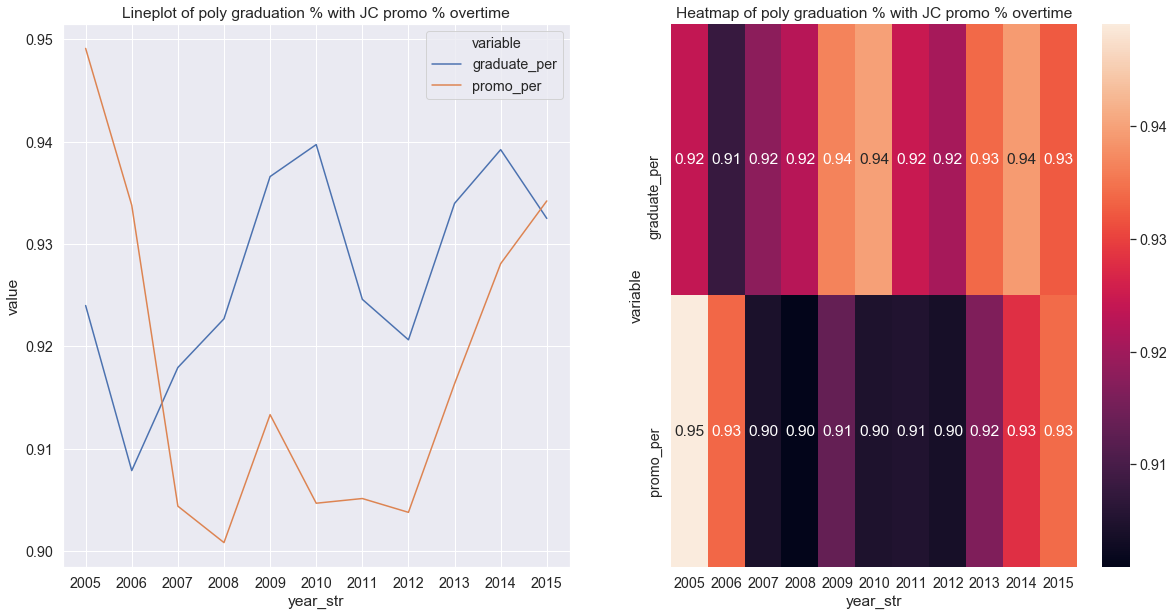

In [29]:
# Filter the data 
grp_grad = df_jc_poly[['year_str', 'graduate_per', 'promo_per']]
grp_grad_m = grp_grad.melt(id_vars=['year_str'], value_vars=['graduate_per', 'promo_per'])
grp_grad_p = grp_grad_m.pivot('variable', 'year_str', 'value')

# creating subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.lineplot('year_str', 'value', hue='variable', data=grp_grad_m, ax=ax[0])
sns.heatmap(grp_grad_p, annot=True, fmt='.2f', ax=ax[1])

# Adding titles
ax[0].set_title('Lineplot of poly graduation % with JC promo % overtime')
ax[1].set_title('Heatmap of poly graduation % with JC promo % overtime')

# Saving the figure
plt.savefig('plots/sub_1_2.png', bbox_inches='tight')

## For sub-objective  
**Which field of study should I go into**

## For the second sub-objective
**Which field of study should I go into**

Datasets used are:
- universities-intake-enrolment-and-graduates-by-course.csv
- graduate-employment-survey-ntu-nus-sit-smu-sutd.csv

In [30]:
# Loading in the datasets
ori_uni_all = pd.read_csv('data/universities-intake-enrolment-and-graduates-by-course.csv', parse_dates=['year'])
ori_uni_grad = pd.read_csv('data/graduate-employment-survey-ntu-nus-sit-smu-sutd.csv', parse_dates=['year'])

First cleaning the poly dataset again  
This time we need to make sure we group the fields by the field of study they are in

In [31]:
# Before
print('Before')
display(ori_poly_all)

# Making sure the original dataset is not touched
poly_all = ori_poly_all

# CLeaning up all missing values
for i in ['intake', 'enrolment', 'graduates']:
    poly_all[i] = poly_all[i].str.replace(',', '')
    poly_all[i] = poly_all[i].str.replace('-', '0')
# Changing the type back to int
poly_all = poly_all.astype({'intake': 'float32', 'enrolment': 'float32', 'graduates': 'float32'})
# Mapping to find the field based on course
course_field_map = {
'Applied Arts': 'arts',
'Architecture, Building & Real Estate': 'arts',
'Business & Administration': 'business',
'Education': 'education',
'Engineering Sciences': 'engineering',
'Health Sciences': 'medicine',
'Humanities & Social Sciences': 'arts',
'Information Technology': 'computing',
'Law': 'law',
'Mass Communication': 'business',
'Natural, Physical & Mathematical Sciences': 'science',
'Services': 'nil'}
poly_all['field'] = poly_all['course'].replace(course_field_map)
# Getting the only total filters of MF
mf_filter = poly_all['sex'].isin(['MF'])

# Getting only totals
df_poly = poly_all[mf_filter]
# Dropping all nil/na values
df_poly = df_poly.replace({'nil': None})
df_poly = df_poly.dropna()
# Dropping columns we will not be using
df_poly = df_poly.drop(['sex', 'course'], axis=1)
# Creating the df by grouping
df_poly = df_poly.groupby(['year', 'field'])['intake', 'enrolment', 'graduates'].sum().reset_index()
df_poly = df_poly.rename(columns={'intake': 'poly_intake', 'enrolment': 'poly_enrol', 'graduates': 'poly_graduates', 'field': 'poly_field'})
# Creating the year_str column
df_poly['year_str'] = df_poly['year'].dt.strftime('%Y')

# After
print('After')
df_poly.head()

Before


,year,sex,course,intake,enrolment,graduates
0,2005-01-01,MF,Applied Arts,1128,2593,550
1,2005-01-01,F,Applied Arts,687,1538,302
2,2005-01-01,MF,"Architecture, Building & Real Estate",515,1466,425
3,2005-01-01,F,"Architecture, Building & Real Estate",312,870,249
4,2005-01-01,MF,Business & Administration,3483,10143,3044
...,...,...,...,...,...,...
331,2018-01-01,F,Mass Communication,500,1420,437
332,2018-01-01,MF,"Natural, Physical & Mathematical Sciences",1232,3794,1353
333,2018-01-01,F,"Natural, Physical & Mathematical Sciences",773,2308,825
334,2018-01-01,MF,Services,1083,3279,1053


After


,year,poly_field,poly_intake,poly_enrol,poly_graduates,year_str
0,2005-01-01,arts,1724.0,4142.0,975.0,2005
1,2005-01-01,business,3931.0,11569.0,3463.0,2005
2,2005-01-01,computing,4122.0,11607.0,3356.0,2005
3,2005-01-01,education,189.0,484.0,111.0,2005
4,2005-01-01,engineering,7826.0,22462.0,6536.0,2005


Cleaning the uni intake dataset  
Similar to the poly dataset, we need to make sure we group by the field of study

In [32]:
# Before
print('Before')
display(ori_uni_all.head())

# Making sure the original dataset is not touched
uni_all = ori_uni_all

# Changing all missing or null values
for i in ['intake', 'enrolment', 'graduates']:
    uni_all[i] = uni_all[i].str.replace(',', '')
    uni_all[i] = uni_all[i].str.replace('-', '0')
# Changing the type back to int
uni_all = uni_all.astype({'intake': 'float32', 'enrolment': 'float32', 'graduates': 'float32'})
# Getting the only total filters of MF
mf_filter = uni_all['sex'].isin(['MF'])
# Mapping based on course
course_field_map = {
'Accountancy': 'business',
'Architecture, Building & Real Estate': 'arts',
'Business & Administration': 'business',
'Dentistry': 'medicine',
'Education': 'education',
'Engineering Sciences': 'engineering',
'Fine & Applied Arts': 'arts',
'Health Sciences': 'medicine',
'Humanities & Social Sciences': 'arts',
'Information Technology': 'computing',
'Law': 'law',
'Mass Communication': 'business',
'Medicine': 'medicine',
'Natural, Physical & Mathematical Sciences': 'science',
'Services': 'nil'}
uni_all['field'] = uni_all['course'].replace(course_field_map)

# Getting only totals
df_uni_all = uni_all[mf_filter]
# Dropping all nil/na values
df_uni_all = df_uni_all.replace({'nil': None})
df_uni_all = df_uni_all.dropna()
df_uni_all = df_uni_all.drop(['sex', 'course'], axis=1)
# Groupping to get df
df_uni_all = df_uni_all.groupby(['year', 'field'])['intake', 'enrolment', 'graduates'].sum().reset_index()
df_uni_all = df_uni_all.rename(columns={'intake': 'uni_intake', 'enrolment': 'uni_enrol', 'graduates': 'uni_graduates', 'field': 'uni_field'})
# Getting the year_str column
df_uni_all['year_str'] = df_uni_all['year'].dt.strftime('%Y')

# After
print('After')
df_uni_all.head()

Before


,year,sex,course,intake,enrolment,graduates
0,2005-01-01,MF,Accountancy,876,2561,706
1,2005-01-01,F,Accountancy,530,1732,495
2,2005-01-01,MF,"Architecture, Building & Real Estate",299,1310,180
3,2005-01-01,F,"Architecture, Building & Real Estate",175,786,106
4,2005-01-01,MF,Business & Administration,1545,5013,1256


After


,year,uni_field,uni_intake,uni_enrol,uni_graduates,year_str
0,2005-01-01,arts,2695.0,8408.0,1852.0,2005
1,2005-01-01,business,2593.0,8218.0,2108.0,2005
2,2005-01-01,computing,773.0,2356.0,562.0,2005
3,2005-01-01,education,0.0,0.0,0.0,2005
4,2005-01-01,engineering,4028.0,16599.0,3859.0,2005


Now we are cleaning the uni graduates dataset  
For this, we need to make sure our fields are correctly done

In [33]:
# Before
print('Before')
display(ori_uni_grad.head())

# Making sure the original dataset is not touched
uni_grad = ori_uni_grad

# Changing all missing or null values
col_change = ['employment_rate_overall', 'employment_rate_ft_perm', 'basic_monthly_mean', 'basic_monthly_median','gross_monthly_mean', 'gross_monthly_median','gross_mthly_25_percentile', 'gross_mthly_75_percentile']
for i in col_change:
    uni_grad[i] = uni_grad[i].str.replace(',', '')
    uni_grad[i] = uni_grad[i].str.replace('-', '0')
    uni_grad[i] = uni_grad[i].str.replace('na', '0')
# Changing the type back to int
col_change_map = dict(zip(col_change, ['float32']*len(col_change)))
uni_grad = uni_grad.astype(col_change_map)
# Mapping schools to the field of study
school_field_mapping = {
'College of Business (Nanyang Business School)': 'business',
'College of Engineering': 'engineering',
'College of Humanities, Arts & Social Sciences': 'arts',
'College of Sciences': 'science',
'National Institute of Education (NIE)': 'education',
'Faculty of Arts & Social Sciences': 'arts',
'NUS Business School': 'business',
'School of Computing': 'computing',
'Faculty of Dentistry': 'medicine',
'School of Design & Environment': 'arts',
'Faculty of Engineering': 'engineering',
'Faculty of Law': 'law',
'YLL School of Medicine': 'medicine',
'Yong Siew Toh Conservatory of Music': 'arts',
'Faculty of Science': 'science',
'School of Accountancy (4-years programme) *': 'business',
'School of Business (4-years programme) *': 'business',
'School of Economics (4-years programme) *': 'business',
'School of Information Systems (4-years programme) *': 'computing',
'School of Social Sciences (4-years programme) *': 'arts',
'School of Law (4-years programme) *': 'law',
'School of Accountancy (4-year programme) *': 'business',
'School of Business (4-year programme) *': 'business',
'School of Economics (4-year programme) *': 'business',
'School of Information Systems (4-year programme) *': 'computing',
'School of Social Sciences (4-year programme) *': 'arts',
'School of Law (4-year programme) *': 'law',
'DigiPen Institute of Technology': 'computing',
'The Glasgow School of Art': 'arts',
'Newcastle University': 'science',
'Technische Universitt Mnchen': 'science',
'The Culinary Institute of America': 'arts',
'Trinity College Dublin': 'science',
'University of Glasgow': 'computing',
'University of Manchester': 'science',
'University of Nevada, Las Vegas': 'business',
'Wheelock College': 'medicine',
'Multidisciplinary Program': 'nil',
'na': 'nil',
'Singapore Institute of Technology -Trinity College Dublin': 'computing',
'Sports Science and Management': 'arts',
'Faculty Of Dentistry': 'medicine',
'Faculty Of Engineering': 'engineering',
'School of Design and Environment': 'arts',
'Yong Loo Lin School (Medicine)': 'medicine',
'Multidisciplinary Programme': 'nil',
'Trinity College Dublin / Singapore Institute of Technology-Trinity College Dublin': 'science',
'University of Liverpool': 'arts',
'Sport Science and Management': 'arts',
'YST Conservatory Of Music': 'arts',
'Yale-NUS College': 'arts',
'Multi-Disciplinary Programme': 'nil',
'Singapore Institute of Technology -Trinity College Dublin / Trinity College Dublin': 'science',
'Singapore Institute of Technology': 'computing'}
uni_grad['field'] = uni_grad['school'].replace(school_field_mapping)

# Grping by the field of study
df_uni_grad = uni_grad.groupby(['year', 'field'])['employment_rate_overall', 'employment_rate_ft_perm', 'basic_monthly_mean', 'basic_monthly_median','gross_monthly_mean', 'gross_monthly_median','gross_mthly_25_percentile', 'gross_mthly_75_percentile'].mean().reset_index()
# Dropping all nil/na values
df_uni_grad = df_uni_grad.replace({'nil': None})
df_uni_grad = df_uni_grad.dropna()
# Getting the year_str column
df_uni_grad['year_str'] = df_uni_grad['year'].dt.strftime('%Y')

# After
print('After')
df_uni_grad.head()

Before


,year,university,school,degree,employment_rate_overall,employment_rate_ft_perm,basic_monthly_mean,basic_monthly_median,gross_monthly_mean,gross_monthly_median,gross_mthly_25_percentile,gross_mthly_75_percentile
0,2013-01-01,Nanyang Technological University,College of Business (Nanyang Business School),Accountancy and Business,97.4,96.1,3701,3200,3727,3350,2900,4000
1,2013-01-01,Nanyang Technological University,College of Business (Nanyang Business School),Accountancy (3-yr direct Honours Programme),97.1,95.7,2850,2700,2938,2700,2700,2900
2,2013-01-01,Nanyang Technological University,College of Business (Nanyang Business School),Business (3-yr direct Honours Programme),90.9,85.7,3053,3000,3214,3000,2700,3500
3,2013-01-01,Nanyang Technological University,College of Business (Nanyang Business School),Business and Computing,87.5,87.5,3557,3400,3615,3400,3000,4100
4,2013-01-01,Nanyang Technological University,College of Engineering,Aerospace Engineering,95.3,95.3,3494,3500,3536,3500,3100,3816


After


,year,field,employment_rate_overall,employment_rate_ft_perm,basic_monthly_mean,basic_monthly_median,gross_monthly_mean,gross_monthly_median,gross_mthly_25_percentile,gross_mthly_75_percentile,year_str
0,2013-01-01,arts,76.538887,66.966667,2626.444336,2582.777832,2689.888916,2626.388916,2362.500000,2918.777832,2013
1,2013-01-01,business,93.557144,90.885712,3316.428467,3044.142822,3424.071533,3121.000000,2832.142822,3622.714355,2013
2,2013-01-01,computing,69.125000,63.587502,2625.125000,2434.375000,2662.750000,2457.500000,2265.625000,2822.250000,2013
3,2013-01-01,education,100.000000,100.000000,3395.000000,3413.000000,3492.000000,3498.000000,3350.000000,3687.500000,2013
4,2013-01-01,engineering,89.368179,85.445457,3163.409180,3056.818115,3251.136475,3126.590820,2959.681885,3485.227295,2013


## Now we will start looking at the data

First lets look at the trend of Poly and Uni students intake in their respective fields


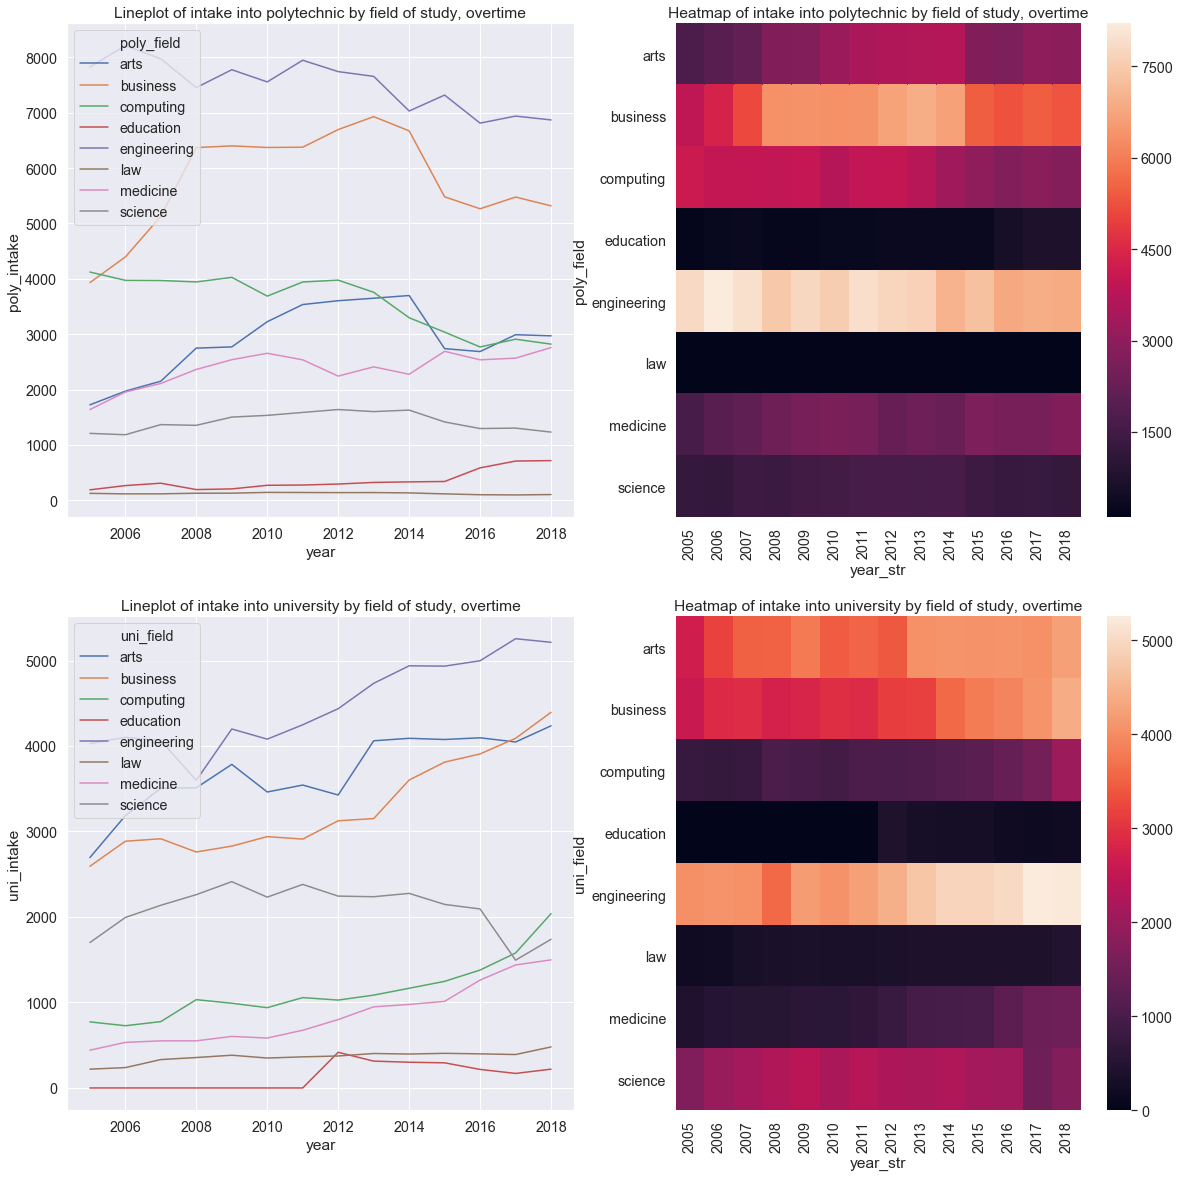

In [34]:
# Getting the data with the needed fields
poly_intake = df_poly[['year_str', 'poly_field', 'poly_intake']]
uni_intake = df_uni_all[['year_str', 'uni_field', 'uni_intake']]

# Pivotting the data to generate the heatmap needed
poly_intake_p = poly_intake.pivot('poly_field', 'year_str', 'poly_intake')
uni_intake_p = uni_intake.pivot('uni_field', 'year_str', 'uni_intake')

# Setting up the subplots
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
sns.lineplot('year', 'poly_intake', hue='poly_field', data=df_poly, ax=ax[0, 0])
sns.heatmap(poly_intake_p, ax=ax[0, 1])

sns.lineplot('year', 'uni_intake', hue='uni_field', data=df_uni_all, ax=ax[1, 0])
sns.heatmap(uni_intake_p, ax=ax[1, 1])


# Adding titles
ax[0, 0].set_title('Lineplot of intake into polytechnic by field of study, overtime')
ax[0, 1].set_title('Heatmap of intake into polytechnic by field of study, overtime')

ax[1, 0].set_title('Lineplot of intake into university by field of study, overtime')
ax[1, 1].set_title('Heatmap of intake into university by field of study, overtime')

# Saving the figure
plt.savefig('plots/sub_2_1.png', bbox_inches='tight')

Now we will normalise the values to get a better sense of which is more popular

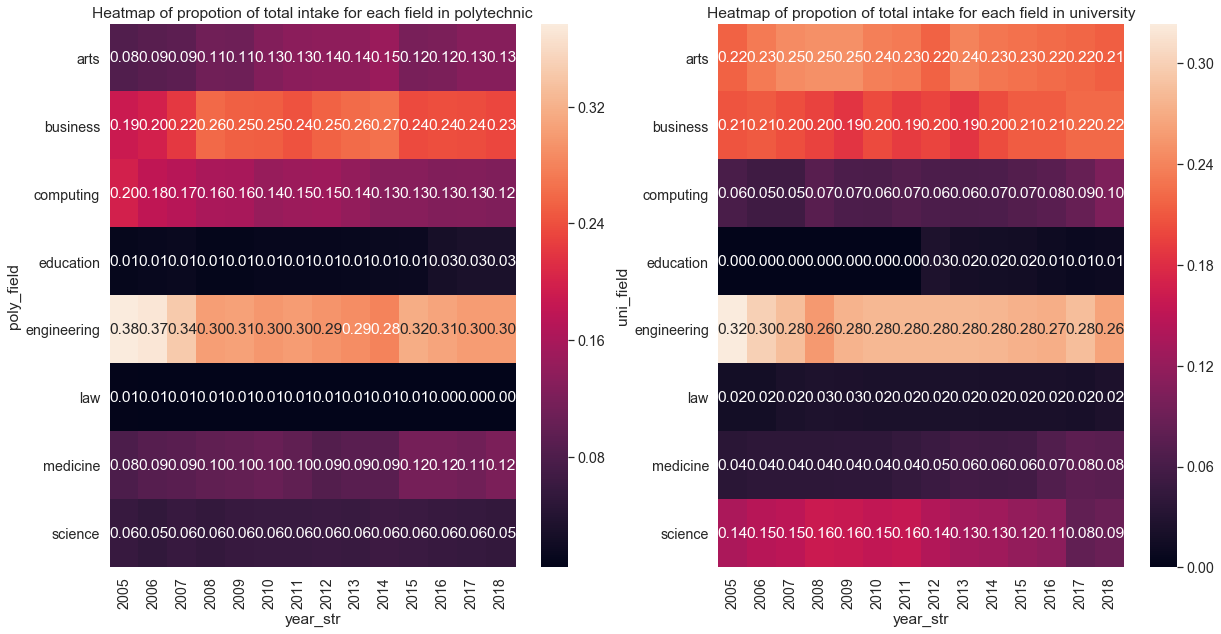

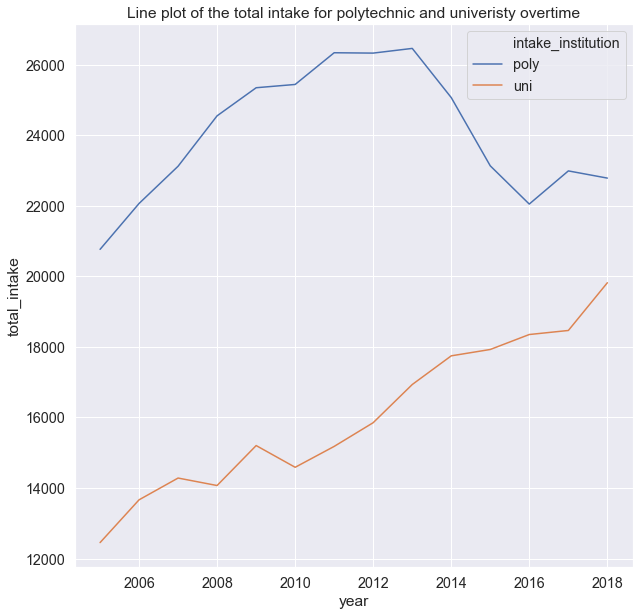

In [35]:
# Getting the data to mainipulate
poly_intake_total = df_poly.groupby(['year'])['poly_intake'].sum().reset_index().rename(columns={'poly_intake': 'intake_total'})
uni_intake_total = df_uni_all.groupby(['year'])['uni_intake'].sum().reset_index().rename(columns={'uni_intake': 'intake_total'})

# Merging the df
poly_merge = pd.merge(df_poly, poly_intake_total, how='left', on=['year'])
uni_merge = pd.merge(df_uni_all, uni_intake_total, how='left', on=['year'])

# Calculating the % of intake for each field
poly_merge['intake_per'] = poly_merge['poly_intake'] / poly_merge['intake_total']
uni_merge['intake_per'] = uni_merge['uni_intake'] / uni_merge['intake_total']

# Manipulating the df for heatmap
poly_intake_per = poly_merge.pivot('poly_field', 'year_str', 'intake_per')
uni_intake_per = uni_merge.pivot('uni_field', 'year_str', 'intake_per')

# Getting the merged poly and uni intake
poly_uni_intake = pd.merge(poly_intake_total, uni_intake_total, how='inner', on='year', suffixes=('_poly', '_uni'))
poly_uni_intake = poly_uni_intake.rename(columns={'intake_total_poly': 'poly', 'intake_total_uni': 'uni'})
poly_uni_intake = poly_uni_intake.melt(id_vars='year', value_vars=['poly', 'uni'], var_name='intake_institution', value_name='total_intake')

# Setting up the subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.heatmap(poly_intake_per, ax=ax[0], annot=True, fmt='.2f')
sns.heatmap(uni_intake_per, ax=ax[1], annot=True, fmt='.2f')

# Adding titles
ax[0].set_title('Heatmap of propotion of total intake for each field in polytechnic')
ax[1].set_title('Heatmap of propotion of total intake for each field in university')

# Saving the figure
plt.savefig('plots/sub_2_2_1.png', bbox_inches='tight')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('year', 'total_intake', hue='intake_institution', data=poly_uni_intake, ax=ax)

# Adding titles
ax.set_title('Line plot of the total intake for polytechnic and univeristy overtime')

# Saving the figure
plt.savefig('plots/sub_2_2_2.png', bbox_inches='tight')


Now we are looking at the employment rate of uni grads by field of study

Some basic graphs

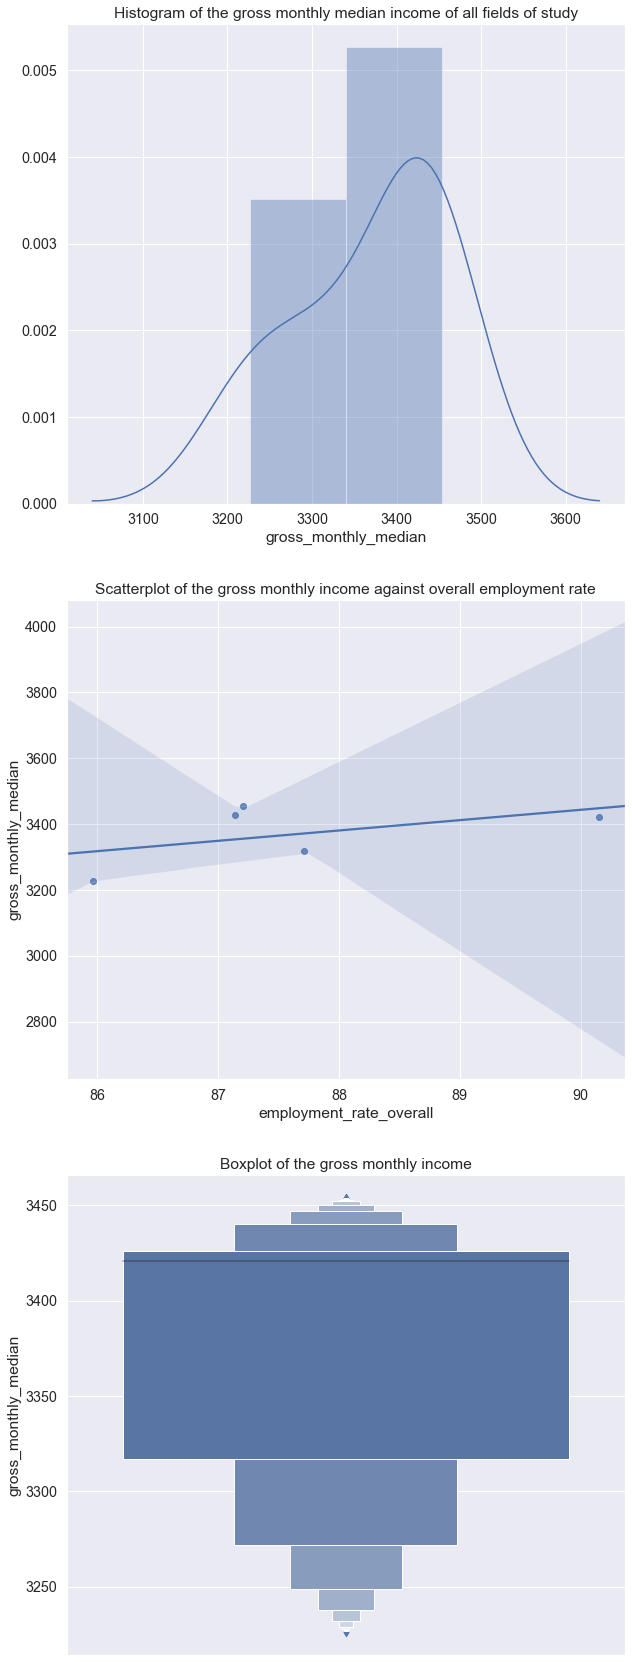

In [43]:
uni_grad_year = df_uni_grad.groupby(['year'])['employment_rate_overall', 'gross_monthly_median'].mean().reset_index()

fig, ax = plt.subplots(3, 1, figsize=(10, 30))

sns.distplot(uni_grad_year['gross_monthly_median'], ax=ax[0], hist=True, kde=True)
sns.regplot(x='employment_rate_overall', y='gross_monthly_median', data=uni_grad_year, ax=ax[1])
sns.boxenplot(y='gross_monthly_median', data=uni_grad_year, ax=ax[2])

# Adding titles
ax[0].set_title('Histogram of the gross monthly median income of all fields of study')
ax[1].set_title('Scatterplot of the gross monthly income against overall employment rate')
ax[2].set_title('Boxplot of the gross monthly income')

# Saving the figure
plt.savefig('plots/sub_3_1.png', bbox_inches='tight')

In [44]:
from bokeh.plotting import figure
from bokeh.io import output_file, show

# Create the figure: p
p = figure(x_axis_label='employment rate overall', y_axis_label='gross monthly median income')

# Add a circle glyph to the figure p
p.circle(uni_grad_year['employment_rate_overall'], uni_grad_year['gross_monthly_median'])

# Display the plot
show(p)

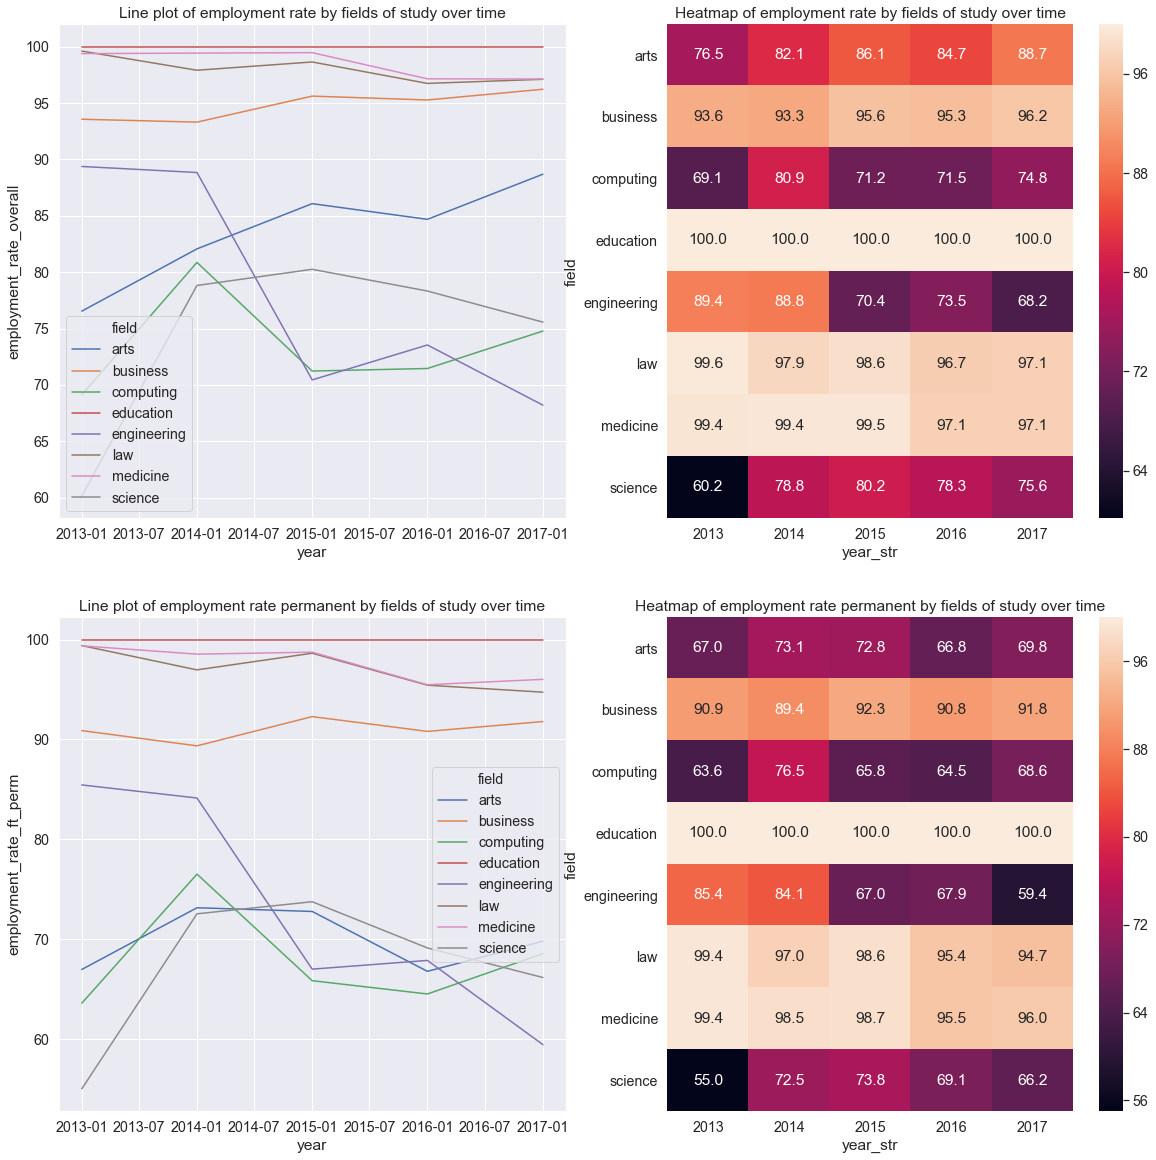

In [45]:
# Manipulating the data to create what I need
uni_employ_overall = df_uni_grad.pivot('field', 'year_str', 'employment_rate_overall')
uni_employ_perm = df_uni_grad.pivot('field', 'year_str', 'employment_rate_ft_perm')

# Getting the subplots
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
sns.lineplot('year', 'employment_rate_overall', hue='field', data=df_uni_grad, ax=ax[0, 0])
sns.heatmap(uni_employ_overall, annot=True, fmt='.1f', ax=ax[0, 1])

sns.lineplot('year', 'employment_rate_ft_perm', hue='field', data=df_uni_grad, ax=ax[1, 0])
sns.heatmap(uni_employ_perm, annot=True, fmt='.1f', ax=ax[1, 1])

# Adding titles
ax[0, 0].set_title('Line plot of employment rate by fields of study over time')
ax[0, 1].set_title('Heatmap of employment rate by fields of study over time')

ax[1, 0].set_title('Line plot of employment rate permanent by fields of study over time')
ax[1, 1].set_title('Heatmap of employment rate permanent by fields of study over time')

# Saving the figure
plt.savefig('plots/sub_4_1.png', bbox_inches='tight')

Looking at the salary by field and the difference in good and bad grades

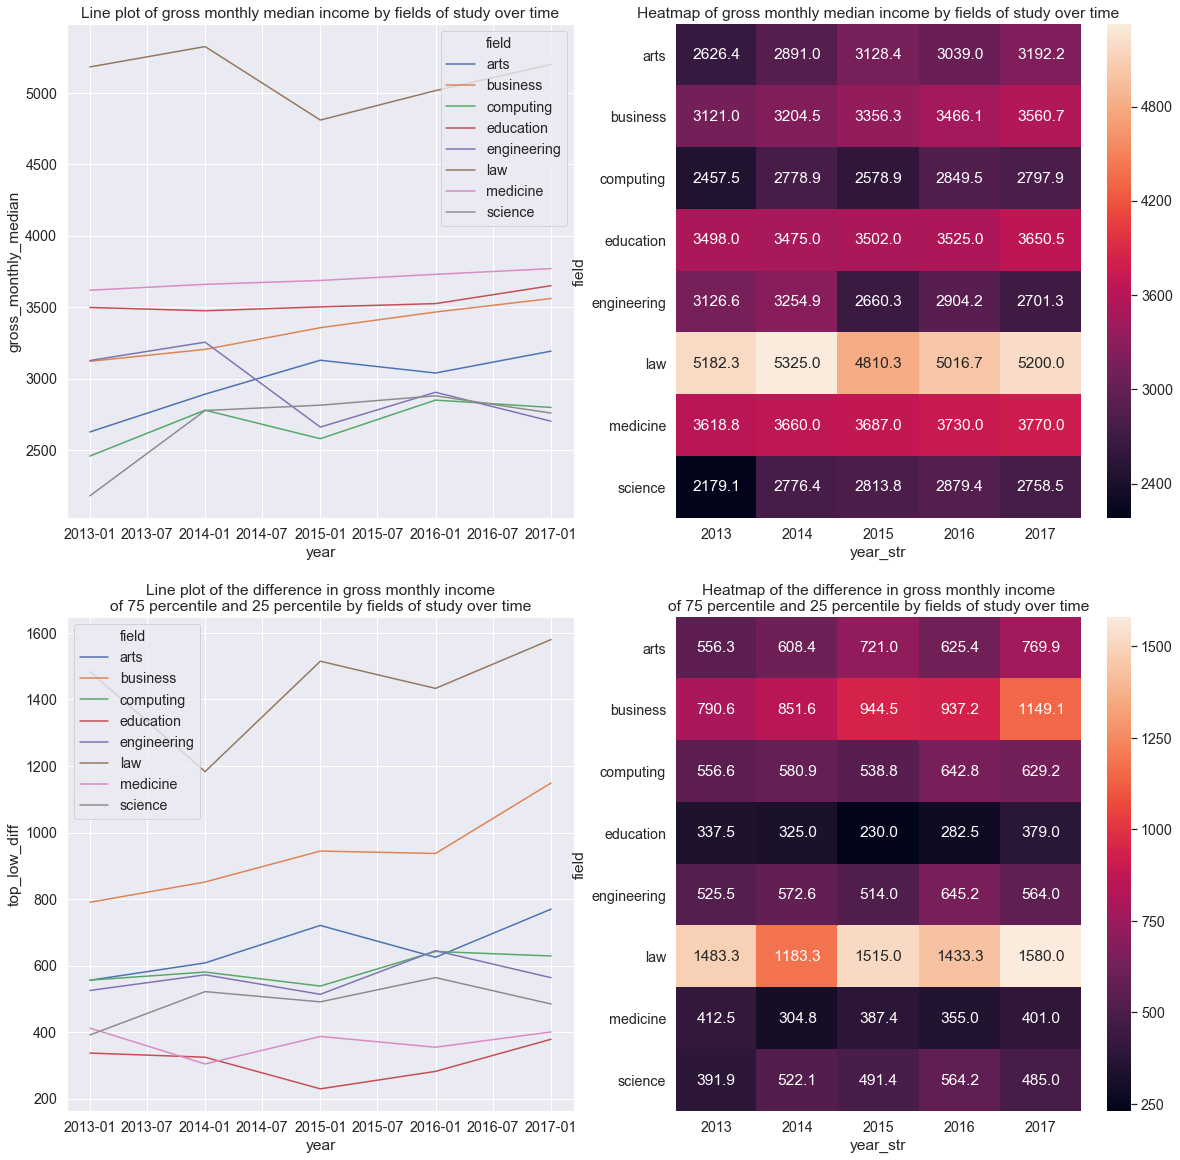

In [46]:
# Getting the df needed for the graphs
uni_grad_salary = df_uni_grad
uni_grad_salary['top_low_diff'] = uni_grad_salary['gross_mthly_75_percentile'] - uni_grad_salary['gross_mthly_25_percentile']

# Pivoting for heatmap
uni_grad_salary_p = uni_grad_salary.pivot('field', 'year_str', 'gross_monthly_median')
uni_top_low_diff_p = uni_grad_salary.pivot('field', 'year_str', 'top_low_diff')

# Setting up the subplots
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

sns.lineplot('year', 'gross_monthly_median', hue='field', data=uni_grad_salary, ax=ax[0, 0])
sns.heatmap(uni_grad_salary_p, annot=True, fmt='.1f', ax=ax[0, 1])

sns.lineplot('year', 'top_low_diff', hue='field', data=uni_grad_salary, ax=ax[1, 0])
sns.heatmap(uni_top_low_diff_p, annot=True, fmt='.1f', ax=ax[1, 1])

# Adding titles
ax[0, 0].set_title('Line plot of gross monthly median income by fields of study over time')
ax[0, 1].set_title('Heatmap of gross monthly median income by fields of study over time')

ax[1, 0].set_title('Line plot of the difference in gross monthly income\nof 75 percentile and 25 percentile by fields of study over time')
ax[1, 1].set_title('Heatmap of the difference in gross monthly income\nof 75 percentile and 25 percentile by fields of study over time')

# Saving the figure
plt.savefig('plots/sub_5_1.png', bbox_inches='tight')